# Predicting the average selling price in the oil gas sector

## 1) Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
#from sklearn.ensemble import GradientBoostingRegressors
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

## 2) Data loading

In [2]:
def load_data(path):
    '''
    This function returns the data set

    -----------
    Parameters
    -----------
    
    path : string
        Directory and name of the file

    -----------
    Returns
    -----------

    df : pandas dataframe
        Dataframe with the data
    '''
    
    df = pd.read_parquet(path)
    
    return df

In [3]:
df = load_data('data/oil_and_gas_dataset.parquet')
df.shape

(556501, 11)

## 3) First glimpse of the data

In [4]:
df.head()

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
0,White Label,BA,Bahia,2917607,Jaguaquara,Gasolina,R$/litro,5,1.723251,2.030526,2004-05-01
1,Blue Label,SP,São Paulo,3550308,São Paulo,Diesel,R$/litro,33,1.225628,1.397636,2004-05-01
2,Green Label,SP,São Paulo,3550308,São Paulo,Diesel,R$/litro,128,1.224991,1.415282,2004-05-01
3,Green Label,SP,São Paulo,3505708,Barueri,Etanol,R$/litro,5,0.619567,0.856467,2004-05-01
4,White Label,SP,São Paulo,3513009,Cotia,Etanol,R$/litro,21,0.604228,0.804345,2004-05-01


Getting information about column names and types:

In [5]:
columns = df.columns.tolist()
columns

['bandeira_revenda_cat',
 'sigla_uf',
 'sigla_uf_nome',
 'id_municipio',
 'id_municipio_nome',
 'produto',
 'unidade_medida',
 'n_estabelecimentos',
 'avg_preco_compra',
 'avg_preco_venda',
 'data']

In [6]:
types = df.dtypes.to_dict()
types

{'bandeira_revenda_cat': dtype('O'),
 'sigla_uf': dtype('O'),
 'sigla_uf_nome': dtype('O'),
 'id_municipio': dtype('O'),
 'id_municipio_nome': dtype('O'),
 'produto': dtype('O'),
 'unidade_medida': dtype('O'),
 'n_estabelecimentos': dtype('int64'),
 'avg_preco_compra': dtype('float64'),
 'avg_preco_venda': dtype('float64'),
 'data': dtype('<M8[ns]')}

Pre-processing the data:

In [11]:
def data_prep(df):
    '''
    This function is responsible for:
        1) Sample the data set
        2) Remove nan values
        3) Tranform categorical into numerical information 
        4) Transform skewed and wide range variable distributions
        5) Create new attributes (based on the raw data)
        6) Remove some attributes

    -----------
    Parameters
    -----------
    
    df : pandas dataframe
        Contains the dataframe with the whole data

    -----------
    Returns
    -----------

    df : pandas dataframe
        The modified dataframe
    '''

    #1) Sampling the data set
    df = df.sample(frac = 1)

    #2) Removing nan values
    df = df.dropna()

    #3) Transforming categorical to numerical information
    LE = LabelEncoder()
    for i in range(len(columns)):
        if types[columns[i]] == 'object':
            df[columns[i]] = LE.fit_transform(df[columns[i]])
        
    #5) Removing columns with unique values
    for i in range(len(columns)):
        if df[columns[i]].unique().shape[0] == 1:
            df = df.drop(columns[i], axis = 1)

    # #4) Creating new data attributes and removing the previous one
    # df['yyyy'] = pd.to_datetime(df['data']).dt.year
    # df['mm'] = pd.to_datetime(df['data']).dt.month
    # df = df.drop('data', axis = 1)
    df.index = pd.to_datetime(df['data'], format='%Y-%m-%d')

    #5) Tranforming skewed and wide range variable distributions
    df['n_estabelecimentos'] = np.log10(df['n_estabelecimentos'])

    return df

In [16]:
df.shape

(556501, 11)

In [17]:
new_df = data_prep(df)
new_df.shape

(331360, 10)

In [18]:
new_df['data']

data
2019-01-01   2019-01-01
2006-07-01   2006-07-01
2017-06-01   2017-06-01
2019-02-01   2019-02-01
2004-05-01   2004-05-01
                ...    
2012-07-01   2012-07-01
2008-06-01   2008-06-01
2008-02-01   2008-02-01
2019-07-01   2019-07-01
2012-07-01   2012-07-01
Name: data, Length: 331360, dtype: datetime64[ns]

In [19]:
new_df.describe()

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
count,331360.000000,331360.000000,331360.000000,331360.000000,331360.000000,331360.000000,331360.000000,331360.000000,331360.000000,331360
mean,1.647009,16.427282,16.429436,353.915780,337.076017,1.045591,0.616984,2.278602,2.632024,2012-08-08 15:37:37.518106880
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.413200,0.668744,2004-05-01 00:00:00
25%,1.000000,10.000000,12.000000,220.000000,177.000000,0.000000,0.301030,1.746553,1.997000,2008-05-01 00:00:00
50%,2.000000,17.000000,17.000000,369.000000,339.000000,1.000000,0.602060,2.190800,2.547333,2013-01-01 00:00:00
75%,3.000000,25.000000,25.000000,482.000000,499.000000,2.000000,0.903090,2.649900,3.075000,2017-03-01 00:00:00
max,3.000000,26.000000,26.000000,660.000000,658.000000,2.000000,3.039811,4.747100,5.438400,2020-08-01 00:00:00
std,1.152768,7.660722,7.456206,170.255904,188.790483,0.822397,0.438201,0.713028,0.800924,NaN


array([[<Axes: title={'center': 'bandeira_revenda_cat'}>,
        <Axes: title={'center': 'sigla_uf'}>,
        <Axes: title={'center': 'sigla_uf_nome'}>],
       [<Axes: title={'center': 'id_municipio'}>,
        <Axes: title={'center': 'id_municipio_nome'}>,
        <Axes: title={'center': 'produto'}>],
       [<Axes: title={'center': 'n_estabelecimentos'}>,
        <Axes: title={'center': 'avg_preco_compra'}>,
        <Axes: title={'center': 'avg_preco_venda'}>],
       [<Axes: title={'center': 'data'}>, <Axes: >, <Axes: >]],
      dtype=object)

<Figure size 640x480 with 0 Axes>

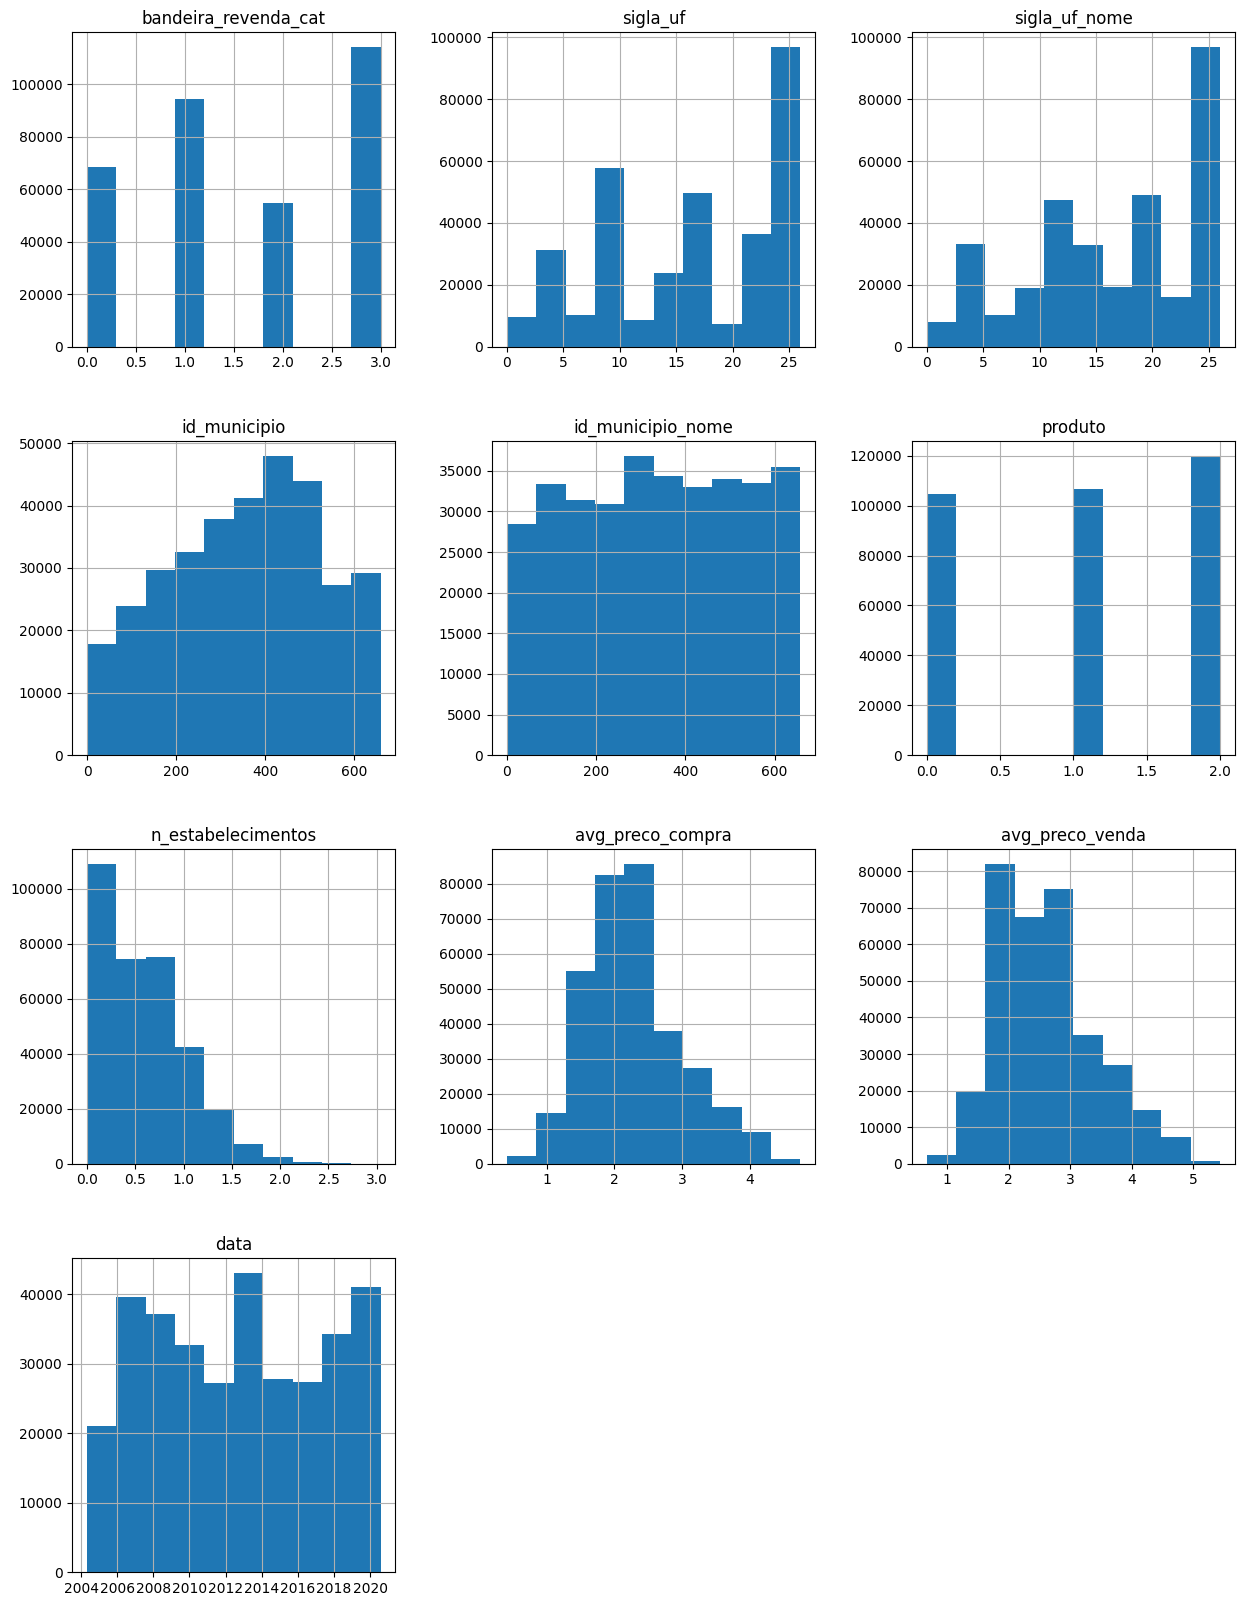

In [20]:
plt.figure(dpi = 100)
new_df.hist(bins = 10, figsize = (15, 20))

In [21]:
df_1 = new_df[new_df['produto'] == 1]
df_1.shape

(106561, 10)

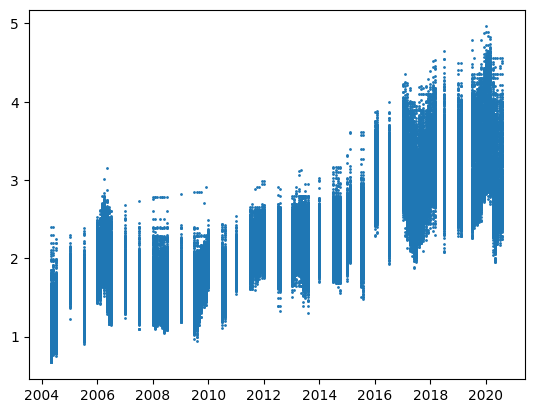

In [25]:
plt.scatter(df_1['data'], df_1['avg_preco_venda'], s = 1)

In [66]:
def correlation_heatmap(df):
    '''
    This function measures the correlation between the variables

    -----------
    Parameters
    -----------
    
    df : pandas dataframe
        Contains the dataframe in question

    -----------
    Returns
    -----------

    correlations :  pandas dataframe
        Constain all the data attributes with its respective correlations
    '''
    
    correlations = df.corr(method = 'pearson')
    
    return correlations

In [68]:
correlation = correlation_heatmap(new_df)

In [69]:
look = correlation['avg_preco_venda'].drop(['avg_preco_venda'])
look

bandeira_revenda_cat   -0.022843
sigla_uf               -0.074477
sigla_uf_nome          -0.068724
id_municipio           -0.056177
id_municipio_nome       0.006574
produto                 0.396685
n_estabelecimentos     -0.059428
avg_preco_compra        0.987650
yyyy                    0.774368
mm                      0.019961
Name: avg_preco_venda, dtype: float64

Text(0.5, 0, 'correlation')

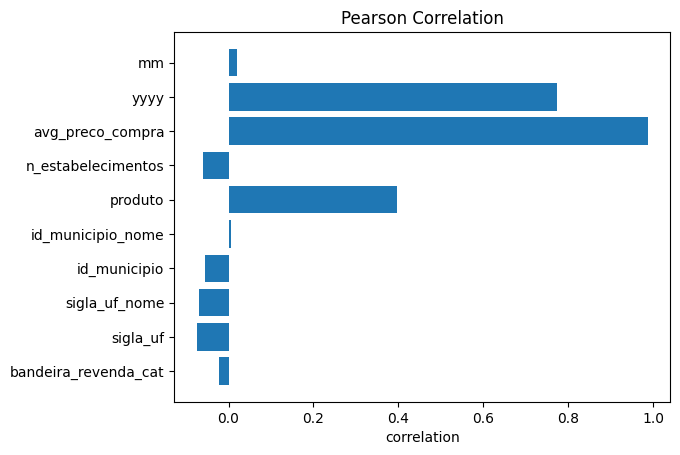

In [70]:
plt.figure(dpi = 100)
plt.title('Pearson Correlation')
plt.barh(look.index, look.values)
plt.xlabel('correlation')

In [71]:
columns = new_df.columns.tolist()
columns

['bandeira_revenda_cat',
 'sigla_uf',
 'sigla_uf_nome',
 'id_municipio',
 'id_municipio_nome',
 'produto',
 'n_estabelecimentos',
 'avg_preco_compra',
 'avg_preco_venda',
 'yyyy',
 'mm']

In [74]:
def selecting_data(df):
    '''
    This function split the corresponding data set into:
        X: input variables
        y: output variables

    -----------
    Parameters
    -----------
    
    df : pandas dataframe
        Contains the dataframe in question

    '''

    X = np.array([df[column] for column in columns]).T
    
    y = np.array([df['avg_preco_venda']]).T

    return X, y

In [75]:
X, y = selecting_data(new_df)
X.shape, y.shape

((331360, 11), (331360, 1))

In [ ]:
model = RandomForestClassifier(random_state = 42, class_weight = 'balanced')